# Hyperparameter tuning

In this notebook, we will evaluate the best parameters for the models Vgg11 and Resnet18 for the Digit dataset.

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm_notebook
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
train_paths = {
    "mnist": "./dataset/mnist/train/",
    "digit": "./dataset/digit/train/",
    "asl": "./dataset/asl/train/",
}

valid_paths = {
    "mnist": "./dataset/mnist/valid/",
    "digit": "./dataset/digit/valid/",
    "asl": "./dataset/asl/valid/",
}


class GroupMDataset(Dataset):
    """
    Definition of the dataset class
    This class will return the input and output needed by the data loader
    """
    
    def __init__(self, root):
        self.root = root
        self.files = os.listdir(root)
        
    def __len__(self):
        return len(self.files)
       
    def __getitem__(self, idx):
        data = torch.load(os.path.join(self.root, self.files[idx]))
        return data["X"], data["y"]

In [3]:
import torch.nn as nn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


plot_directory = "./plots/"

models = {
    "resnet18": torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False),
    # "vgg11": torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False),
    # "mobilenet_v2": torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
}


def metrics_loss_scores(y_true, y_pred, loss_per_batch):
    """
    Description: This function gives training metrics for one model.
    Return:
    - score_metrics: a tuple (accuracy, precision, recall, f1 score),
    - score_loss: a float value
    """
    
    score_metrics = (
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, average='micro', zero_division=np.nan),
        recall_score(y_true, y_pred, average='micro', zero_division=np.nan),
        f1_score(y_true, y_pred, average='micro', zero_division=np.nan)
    )

    score_loss = sum(loss_per_batch) / len(loss_per_batch)

    return score_metrics, score_loss
    

def train_model(model, optimizer, criterion, train_loader: DataLoader):
    """
    Description: This function trains the model and give the results for one model.
    Return:
    - score_metrics: a list of tuple (accuracy, precision, recall, f1 score),
    - score_loss: a float value
    """

    y_pred = []
    y_true = []
    loss_per_batch = []

    # Training
    for i, data in enumerate(train_loader):
        # Data conversion for cuda
        X_batch, y_batch = data[0], data[1]
        X_batch = X_batch.cuda()
        y_batch = y_batch.type(torch.LongTensor)
        y_batch = y_batch.cuda()
        
        # Updating the model
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu())
        y_true.extend(y_batch.cpu())
        loss_per_batch.append(loss.item())

    return metrics_loss_scores(y_true, y_pred, loss_per_batch)


def valid_model(model, criterion, valid_loader: DataLoader):
    """
    Description: This function gives validation results for one model.
    Return:
    - score_metrics: a list of tuple (accuracy, precision, recall, f1 score),
    - score_loss: a float value
    """

    y_pred = []
    y_true = []
    loss_per_batch = []

    with torch.no_grad():
        for data in valid_loader:
            X_batch, y_batch = data[0].cuda(), data[1]
            y_batch = y_batch.type(torch.LongTensor)
            y_batch = y_batch.cuda()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            _, predicted = torch.max(outputs.data, 1)
            
            # Adding the current batch data to y_pred and y_true
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
            loss_per_batch.append(loss.item())

    return metrics_loss_scores(y_true, y_pred, loss_per_batch)


def train_valid(poptimizer, model, criterion, optimizer, train_loader: DataLoader, valid_loader: DataLoader, n_epochs: int = 20, name_model: str = 'mnist', name_optimizer: str = "SGD"):

    models_train_score_metrics, models_train_score_loss = [], []
    models_valid_score_metrics, models_valid_score_loss = [], []

    with tqdm_notebook(range(n_epochs), desc=name_optimizer + " - Training of " + name_model) as tepoch:
        for epoch in range(n_epochs):

            train_score_metrics, train_score_loss = train_model(
                model=model,
                optimizer=optimizer,
                criterion=criterion,
                train_loader=train_loader
            )

            models_train_score_metrics.append(train_score_metrics)
            models_train_score_loss.append(train_score_loss)
        
            valid_score_metrics, valid_score_loss = valid_model(model=model, criterion=criterion, valid_loader=valid_loader)

            models_valid_score_metrics.append(valid_score_metrics)
            models_valid_score_loss.append(valid_score_loss)

            tepoch.set_postfix(loss=train_score_loss, accuracy=train_score_metrics[0], valid_loss=valid_score_loss,
                               valid_accuracy=valid_score_metrics[0])
            tepoch.update(1)
            poptimizer.update(1)

    return models_train_score_metrics, models_train_score_loss, models_valid_score_metrics, models_valid_score_loss


def hyperparameter_tuning_optimizers(train_loader: DataLoader, valid_loader: DataLoader, optimizers, n_epochs: int = 20, name_dataset: str = "mnist"):

    name_optimizers = list(optimizers.keys())
    
    train_losses = {name_optimizer: {} for name_optimizer in name_optimizers}
    train_accuracy = {name_optimizer: {} for name_optimizer in name_optimizers}
    val_losses = {name_optimizer: {} for name_optimizer in name_optimizers}
    val_accuracy = {name_optimizer: {} for name_optimizer in name_optimizers}


    with tqdm_notebook(range(len(optimizers) * n_epochs), desc="HyperTuning Optimizer") as poptimizer:
        for name_optimizer, optimizer in optimizers.items():
            poptimizer.set_description("HyperTuning %s" % name_optimizer)
            
            models = {
                "resnet18": torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False),
                # "vgg11": torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False),
                # "mobilenet_v2": torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
            }
            
            for name_model, model in models.items():
                model.cuda()
    
                models_optimizers = {
                    "resnet18": optimizer(model.parameters(), lr=0.001),
                    "vgg11": optimizer(model.parameters(), lr=0.0001),
                    "mobilenet_v2": optimizer(model.parameters(), lr=0.001)
                }

                criterion = nn.CrossEntropyLoss()
                optimizer = models_optimizers[name_model]
    
                train_score, train_loss, valid_score, valid_loss = train_valid(
                    poptimizer=poptimizer,
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    valid_loader=valid_loader,
                    n_epochs=n_epochs,
                    name_model=name_model,
                    name_optimizer=name_optimizer
                )
    
                train_accuracy[name_optimizer][name_model] = train_score
                train_losses[name_optimizer][name_model] = train_loss
                val_accuracy[name_optimizer][name_model] = valid_score
                val_losses[name_optimizer][name_model] = valid_loss
    torch.cuda.empty_cache()
                       
    return train_accuracy, train_losses, val_accuracy, val_losses

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


In [4]:
def plot_score_loss(score, loss, params, name_set: str = "Training", name_param_ht: str = "Optimizer"):
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 3))
    
    for name_param in list(params.keys()):
        for name_model in list(models.keys()):
    
            accuracies, precision, recall, f1_score = [], [], [], []
    
            for metric in score[name_param][name_model]:
                accuracies.append(metric[0])
                precision.append(metric[1])
                recall.append(metric[2])
                f1_score.append(metric[3])
    
            num = [i for i in range(len(score[name_param][name_model]))]
        
            axes[0].plot(num, accuracies, label=f'{name_param}')
    
    for name_param in list(params.keys()):
        for name_model in list(models.keys()):
    
            num = [i for i in range(len(loss[name_param][name_model]))]
            axes[1].plot(num, loss[name_param][name_model], label=f'{name_param}')

    axes[0].set_title(name_set + " accuracies")
    axes[1].set_title(name_set + " losses")
    axes[0].set_xlabel("Epochs")
    axes[1].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("Loss")
    axes[0].legend()
    axes[1].legend()

    plt.savefig(plot_directory + "resnet18_tuning_" + name_param_ht.lower() + "_" + name_set.lower() + ".pdf", format="pdf", bbox_inches="tight")

    

In [5]:
train_dataset = GroupMDataset(train_paths["digit"])
valid_dataset = GroupMDataset(valid_paths["digit"])

train_loader = DataLoader(train_dataset, num_workers=8, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, num_workers=8, batch_size=16, shuffle=True)

optimizers = {"SGD": torch.optim.SGD, "RMSprop": torch.optim.RMSprop, "Adam": torch.optim.Adam, "Adamax": torch.optim.Adamax, "NAdam": torch.optim.NAdam}
# optimizers = {"SGD": torch.optim.SGD, "RMSprop": torch.optim.RMSprop, "Adam": torch.optim.Adam, "NAdam": torch.optim.NAdam}
# optimizers = {"RMSprop": torch.optim.RMSprop, "Adamax": torch.optim.Adamax, "Adam": torch.optim.Adam, "NAdam": torch.optim.NAdam}

train_accuracy, train_losses, val_accuracy, val_losses = hyperparameter_tuning_optimizers(
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizers=optimizers,
    n_epochs=10,
    name_dataset="digit"
)

HyperTuning Optimizer:   0%|          | 0/50 [00:00<?, ?it/s]

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


SGD - Training of resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


RMSprop - Training of resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


Adam - Training of resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


Adamax - Training of resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


NAdam - Training of resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

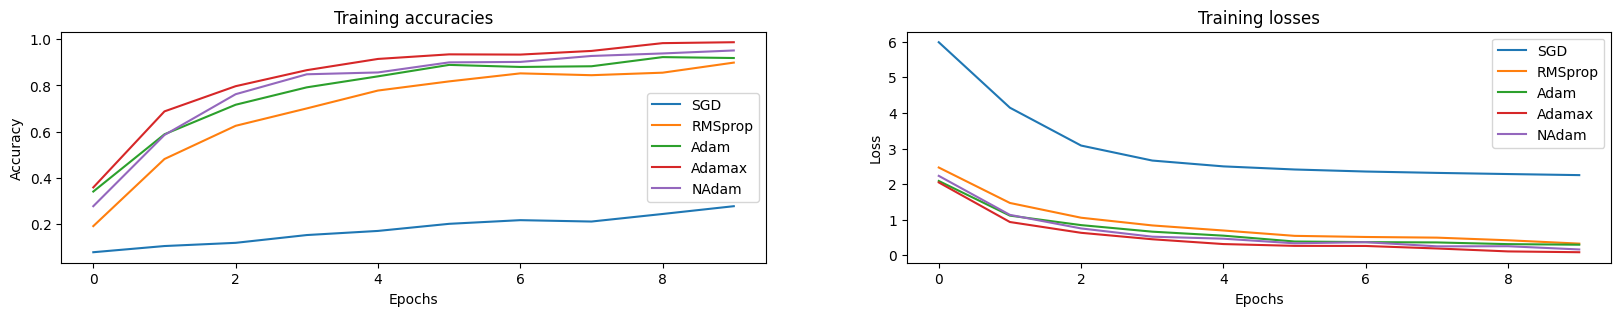

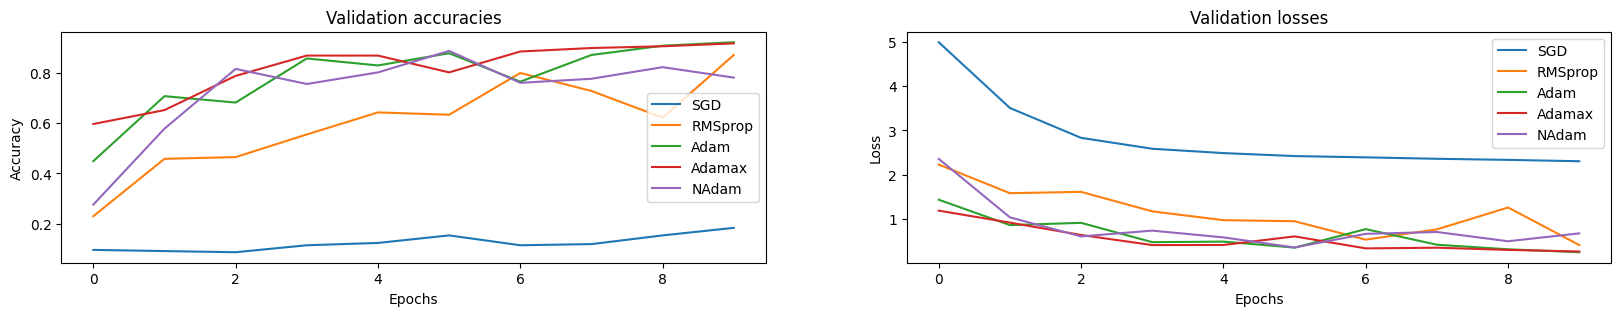

In [6]:
plot_score_loss(score=train_accuracy, loss=train_losses, params=optimizers, name_set="Training")
plot_score_loss(score=val_accuracy, loss=val_losses, params=optimizers, name_set="Validation")

In [7]:
def hyperparameter_tuning_params(train_loader: DataLoader, valid_loader: DataLoader, params, n_epochs: int = 20, name_dataset: str = "mnist"):

    train_losses = {str(lr): {} for lr in params['lr']}
    train_accuracy = {str(lr): {} for lr in params['lr']}
    val_losses = {str(lr): {} for lr in params['lr']}
    val_accuracy = {str(lr): {} for lr in params['lr']}


    with tqdm_notebook(range(len(params['lr'] * n_epochs)), desc="HyperTuning Params") as poptimizer:
        for lr in params['lr']:
            poptimizer.set_description("HyperTuning %s" % str(lr))

            models = {
                "resnet18": torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False),
                # "vgg11": torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False),
                # "mobilenet_v2": torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
            }
            for name_model, model in models.items():
                model.cuda()
    
                models_optimizers = {
                    "resnet18": torch.optim.Adamax(model.parameters(), lr=lr),
                    "vgg11": torch.optim.RMSprop(model.parameters(), lr=lr),
                    "mobilenet_v2": torch.optim.NAdam(model.parameters(), lr=lr)
                }
    
                criterion = nn.CrossEntropyLoss()
                optimizer = models_optimizers[name_model]
    
                train_score, train_loss, valid_score, valid_loss = train_valid(
                    poptimizer=poptimizer,
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    valid_loader=valid_loader,
                    n_epochs=n_epochs,
                    name_model=name_model,
                    name_optimizer=str(lr)
                )
    
                train_accuracy[str(lr)][name_model] = train_score
                train_losses[str(lr)][name_model] = train_loss
                val_accuracy[str(lr)][name_model] = valid_score
                val_losses[str(lr)][name_model] = valid_loss
    torch.cuda.empty_cache()
                       
    return train_accuracy, train_losses, val_accuracy, val_losses

In [8]:
params = {"lr": [0.1, 0.01, 0.001, 0.0001, 0.00001]}

models = {
    "resnet18": torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False),
    # "vgg11": torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False),
    # "mobilenet_v2": torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
}

train_accuracy, train_losses, val_accuracy, val_losses = hyperparameter_tuning_params(
    train_loader=train_loader,
    valid_loader=valid_loader,
    params=params,
    n_epochs=10,
    name_dataset="digit"
)

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


HyperTuning Params:   0%|          | 0/50 [00:00<?, ?it/s]

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


0.1 - Training of resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


0.01 - Training of resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


0.001 - Training of resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


0.0001 - Training of resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

Using cache found in /home/atlanta/.cache/torch/hub/pytorch_vision_v0.10.0


1e-05 - Training of resnet18:   0%|          | 0/10 [00:00<?, ?it/s]

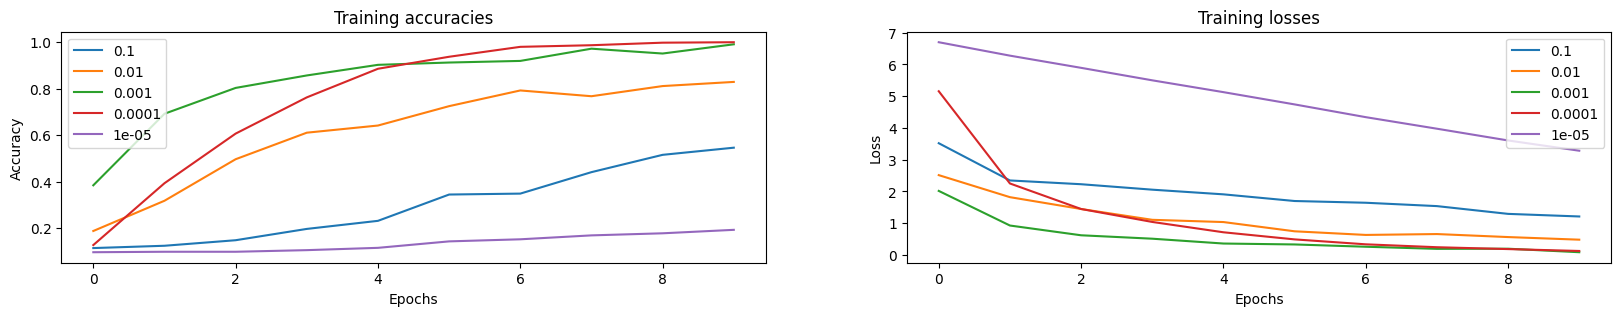

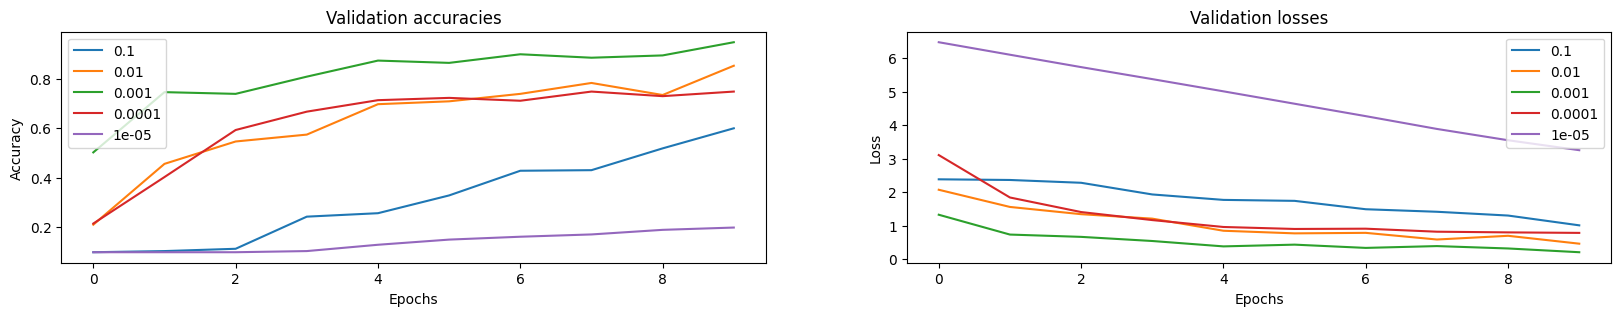

In [9]:
params_lr = {str(lr): {} for lr in params['lr']}
plot_score_loss(score=train_accuracy, loss=train_losses, params=params_lr, name_set="Training", name_param="lr")
plot_score_loss(score=val_accuracy, loss=val_losses, params=params_lr, name_set="Validation", name_param="lr")